In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle

In [0]:
CASU_16_11_1_mag = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/UKIRT/CASU_16_11_1_mag.pkl', 'rb'))
CASU_16_11_1_emag = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/UKIRT/CASU_16_11_1_emag.pkl', 'rb'))

microlensing_mag = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/UKIRT/microlensing_mag.pkl', 'rb'))
microlensing_emag = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/UKIRT/microlensing_emag.pkl', 'rb'))

In [4]:
CASU_16_11_1_mag

hjd,7487.06988,7487.11495,7488.04462,7488.09038,7489.04510,7489.10259,7490.05190,7490.10377,7491.05685,7491.10734,7492.05271,7492.10341,7493.04391,7493.09400,7494.03789,7494.08453,7495.04279,7495.09225,7496.03225,7496.09040,7497.04919,7497.09512,7498.01350,7498.05915,7499.04435,7499.08873,7500.02532,7500.07202,7501.00590,7501.05264,7502.01901,7502.06336,7503.01180,7503.05801,7507.01340,7507.06425,7508.02649,7508.07036,7509.01677,7509.06933,...,7551.00329,7554.91909,7554.96542,7555.01010,7555.88051,7555.92447,7555.97284,7558.89322,7558.93890,7558.98359,7561.88825,7561.93324,7561.98245,7562.84046,7562.88893,7562.93556,7563.87604,7563.92058,7563.96431,7564.87199,7564.91742,7564.96746,7565.98442,7567.91503,7568.87641,7573.81477,7573.86632,7573.91384,7574.82639,7574.87424,7574.92093,7575.80421,7575.85813,7575.90717,7576.82917,7576.87581,7576.92400,7577.80493,7577.85231,7577.89861
0000230,14.989,15.017,14.995,15.047,15.002,15.007,14.986,14.997,14.906,15.031,14.996,15.005,14.978,NaN,14.995,NaN,14.967,NaN,NaN,NaN,14.944,14.989,14.988,14.986,14.957,15.002,14.988,15.002,15.046,14.991,14.993,15.048,14.954,15.047,15.000,14.996,14.996,15.012,14.982,15.014,...,14.990,14.986,15.015,NaN,14.979,15.025,15.044,14.993,15.006,NaN,15.008,15.002,15.033,14.934,14.948,14.996,14.984,15.006,14.982,14.985,14.996,14.986,15.011,NaN,14.952,14.996,14.995,15.014,14.960,15.011,14.945,14.985,15.008,15.008,14.989,14.964,14.994,14.971,14.989,14.963
0000243,12.842,12.857,12.833,12.873,12.835,12.842,12.808,12.841,12.834,12.860,12.817,12.849,12.861,12.852,12.836,12.861,12.834,12.857,12.806,NaN,12.829,12.861,12.823,12.848,12.817,12.851,12.841,12.848,12.843,12.860,12.875,12.882,12.846,12.873,12.838,12.838,12.850,12.873,12.853,12.833,...,12.830,12.832,12.831,12.839,12.838,12.863,12.849,12.833,12.828,12.824,12.852,12.842,12.851,12.801,12.815,12.831,12.818,12.850,12.825,12.826,12.832,12.825,12.818,12.843,12.822,12.829,12.821,12.861,12.830,12.854,12.802,12.833,12.838,12.815,12.823,12.824,12.822,12.819,12.828,12.820
0000248,14.998,14.969,14.999,14.990,14.982,14.945,14.924,15.001,15.053,15.003,15.092,15.009,15.059,NaN,14.976,14.964,14.961,14.940,14.972,NaN,15.033,15.009,14.978,14.978,14.994,15.020,14.979,14.965,15.027,15.021,15.029,15.066,14.996,14.978,14.966,14.961,14.992,14.999,14.977,14.968,...,14.994,15.072,14.971,NaN,14.985,15.018,14.994,14.999,14.978,14.992,14.964,14.940,14.996,14.981,14.978,14.942,14.965,15.021,15.035,14.962,14.964,14.976,14.973,14.991,15.058,14.970,15.000,14.974,14.996,14.965,15.024,14.985,14.931,14.921,14.956,14.956,14.927,14.989,14.978,15.040
0000256,16.748,16.578,16.574,16.500,16.547,16.491,16.612,16.620,NaN,16.622,NaN,16.603,16.872,NaN,16.529,NaN,16.538,NaN,NaN,NaN,16.860,16.727,16.610,16.789,16.799,16.956,16.511,16.539,16.951,16.641,16.771,16.864,16.675,16.573,16.504,16.572,16.484,16.650,16.600,NaN,...,16.589,16.968,16.505,NaN,16.595,16.609,16.534,16.565,16.667,NaN,16.568,16.469,16.579,16.701,16.704,16.509,16.619,16.682,16.750,16.544,16.571,16.546,16.535,NaN,16.667,16.560,16.407,16.665,16.687,16.517,16.717,16.519,16.417,16.385,16.601,16.594,16.441,16.738,16.676,16.963
0000259,16.846,16.859,16.725,16.884,16.805,16.735,16.638,16.843,NaN,16.919,NaN,16.876,16.993,16.937,16.945,16.860,16.971,16.785,NaN,NaN,17.096,17.035,16.857,16.808,16.952,17.049,16.921,16.884,16.940,16.832,16.972,16.919,16.967,16.881,16.927,16.819,16.904,16.986,16.956,16.844,...,16.897,17.247,16.870,16.896,16.917,16.913,16.778,16.935,17.012,16.818,16.894,16.886,16.936,16.881,16.876,16.900,16.759,17.032,16.935,16.835,16.963,16.926,16.864,16.895,16.984,16.871,16.789,16.998,16.921,16.906,17.023,16.830,16.804,16.775,16.772,16.930,16.861,16.954,16.940,16.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00899

In [0]:
import numpy as np
def normalize(seq, predict_window=None):
    seq_avg = np.mean(seq[:predict_window][~np.isnan(seq[:predict_window])])
    seq_std = np.std(seq[:predict_window][~np.isnan(seq[:predict_window])])
    seq = (seq - seq_avg) / seq_std    
    return seq

def preprocessUKIRT(data):
  data = np.array(data)
  X_data = np.zeros((data.shape[0],data.shape[1], 1))
  for i in range(len(data)):
    g = data[i]
    X_data[i,:,0] = np.nan_to_num(normalize(g, int(len(g)/5)))
  return X_data

In [0]:
X_CASU_16_11_1_mag = preprocessUKIRT(CASU_16_11_1_mag)
X_CASU_16_11_1_emag = preprocessUKIRT(CASU_16_11_1_emag)

In [0]:
pickle.dump(X_CASU_16_11_1_mag, open('/content/drive/My Drive/pTSA_microlensing/UKIRT/X_CASU_16_11_1_mag.pkl', 'wb'))
pickle.dump(X_CASU_16_11_1_emag, open('/content/drive/My Drive/pTSA_microlensing/UKIRT/X_CASU_16_11_1_emag.pkl', 'wb'))


In [0]:
X_microlensing_mag = preprocessUKIRT(microlensing_mag)
X_microlensing_emag = preprocessUKIRT(microlensing_emag)

In [0]:
# X_microlensing_mag[:3] + X_microlensing_mag[-2:]
X_microlensing_mag = X_microlensing_mag[np.array([0,1,2,6,7])]
X_microlensing_emag = X_microlensing_emag[np.array([0,1,2,6,7])]

In [0]:
pickle.dump(X_microlensing_mag, open('/content/drive/My Drive/pTSA_microlensing/UKIRT/X_microlensing_mag.pkl', 'wb'))
pickle.dump(X_microlensing_emag, open('/content/drive/My Drive/pTSA_microlensing/UKIRT/X_microlensing_emag.pkl', 'wb'))


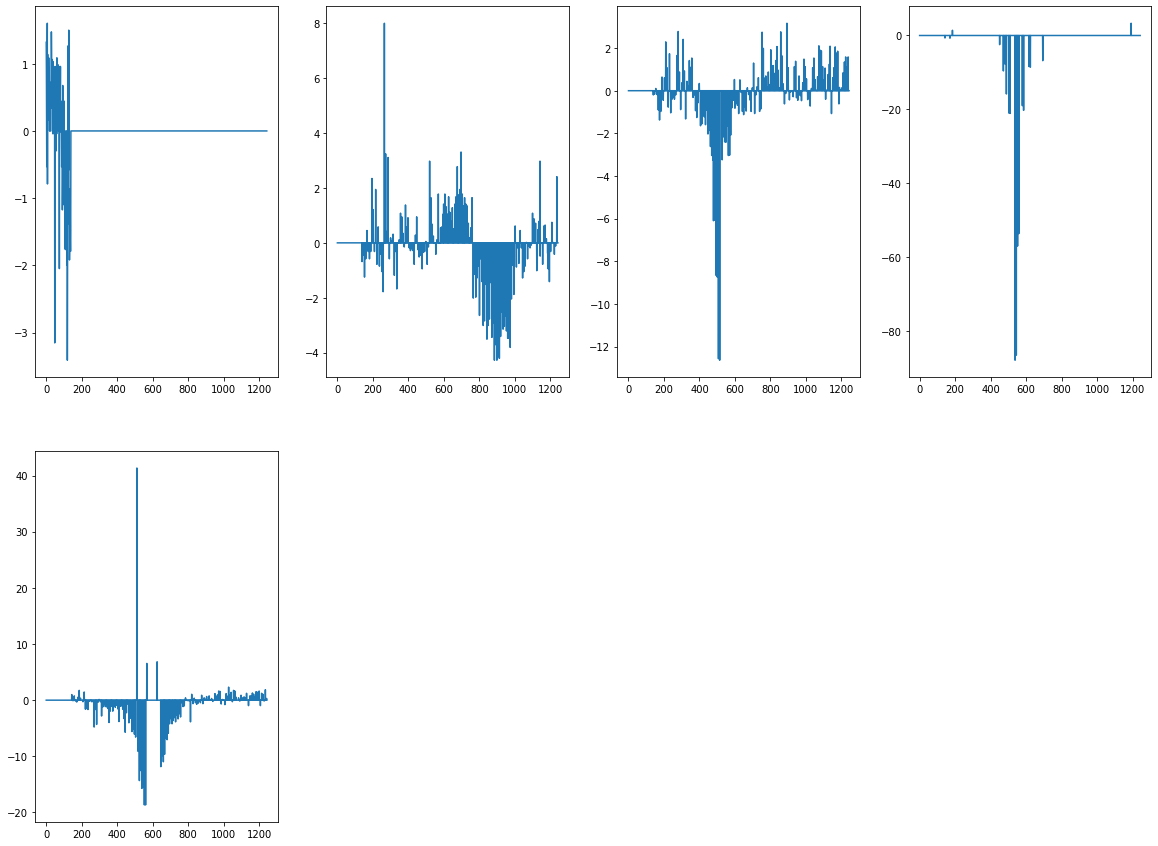

In [105]:
plt.figure(figsize=(20,15))
for i in range(len(X_microlensing_mag[np.array([0,1,2,6,7])])):
  plt.subplot(2,4,i+1)
  plt.plot(X_microlensing_mag[np.array([0,1,2,6,7])][i])
plt.show()


# Add ARIMA Data

In [63]:
pip install pyflux 

     |████████████████████████████████| 1.3MB 9.0MB/s 
     |████████████████████████████████| 962kB 35.9MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656534 sha256=6490b587bcc27de6ebab9ab6509f004d62021c0557b7f57388c79ca8f66322f0
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


In [0]:
import matplotlib.pyplot as plt

In [0]:
from tqdm import tqdm
import pyflux as pf
import numpy as np

def generate_arima_predictions(data, params):
  # data = np.squeeze(data)
  ar, integ, ma = params
  num_dataset = data.shape[0]
  max_t = data.shape[1]
  predict_window = int(0.2 * max_t)
  X_out = np.zeros((num_dataset, max_t, 1))
  
  for i, x in tqdm(enumerate(data)):
    print(x.shape)
    model=pf.ARIMA(data=x,ar=ar, integ=integ, ma=ma, family=pf.Normal())
    model.fit('MLE')
    print(max_t-predict_window)
    hs = model.predict_is(h=(max_t-predict_window))
    # x_sim = np.concatenate((x[:predict_window], hs['Differenced Series']))
    x_sim = np.concatenate((x[:predict_window], hs['Series']))
    X_out[i,:,0] = x_sim
  return X_out

In [0]:
model=pf.ARIMA(data=X_CASU_16_11_1_mag[0,:,0],ar=0, integ=0, ma=2, family=pf.Normal())
fit = model.fit('MLE')

In [67]:
fit.summary()

Normal ARIMA(0,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 2                                           Log Likelihood: -185.5954                         
End Date: 161                                           AIC: 379.1907                                     
Number of observations: 160                             BIC: 391.4914                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0717    0.0679     -1.0557  0.2911   (-0.2048 | 0.0614)       
MA(1)                                

In [73]:
X_CASU_16_11_1_mag[0,:,0].shape[0]

162

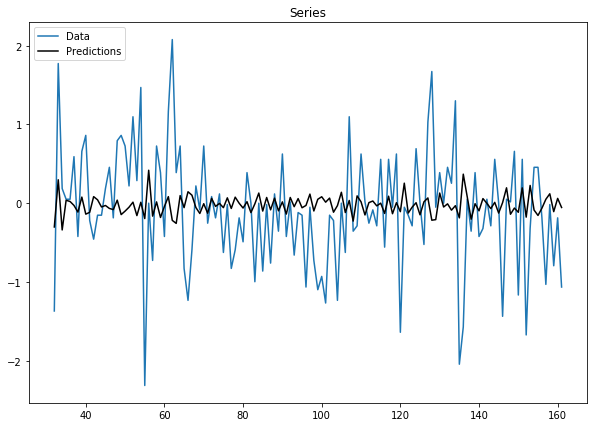

In [74]:
max_t = X_CASU_16_11_1_mag[0,:,0].shape[0]
predict_window = int(0.2 * max_t)
model.plot_predict_is(max_t-predict_window)

In [86]:
X_CASU_16_11_1_mag_arima_1_0_0 = generate_arima_predictions(X_CASU_16_11_1_mag[:40,:,0], (1,0,0))

0it [00:00, ?it/s]

(162,)
130


1it [00:00,  2.53it/s]

(162,)
130


2it [00:00,  2.52it/s]

(162,)
130


3it [00:01,  2.51it/s]

(162,)
130


4it [00:01,  2.53it/s]

(162,)
130


5it [00:01,  2.52it/s]

(162,)
130


6it [00:02,  2.54it/s]

(162,)
130


7it [00:02,  2.56it/s]

(162,)
130


8it [00:03,  2.56it/s]

(162,)
130


9it [00:03,  2.57it/s]

(162,)
130


10it [00:03,  2.59it/s]

(162,)
130


11it [00:04,  2.58it/s]

(162,)
130


12it [00:04,  2.56it/s]

(162,)
130


13it [00:05,  2.55it/s]

(162,)
130


14it [00:05,  2.54it/s]

(162,)
130


15it [00:05,  2.54it/s]

(162,)
130


16it [00:06,  2.56it/s]

(162,)
130


17it [00:06,  2.59it/s]

(162,)
130


18it [00:07,  2.59it/s]

(162,)
130


19it [00:07,  2.57it/s]

(162,)
130


20it [00:07,  2.57it/s]

(162,)
130


21it [00:08,  2.58it/s]

(162,)
130


22it [00:08,  2.58it/s]

(162,)
130


23it [00:08,  2.58it/s]

(162,)
130


24it [00:09,  2.59it/s]

(162,)
130


25it [00:09,  2.60it/s]

(162,)
130


26it [00:10,  2.61it/s]

(162,)
130


27it [00:10,  2.62it/s]

(162,)
130


28it [00:10,  2.62it/s]

(162,)
130


29it [00:11,  2.61it/s]

(162,)
130


30it [00:11,  2.61it/s]

(162,)
130


31it [00:12,  2.61it/s]

(162,)
130


32it [00:12,  2.62it/s]

(162,)
130


33it [00:12,  2.63it/s]

(162,)
130


34it [00:13,  2.62it/s]

(162,)
130


35it [00:13,  2.63it/s]

(162,)
130


36it [00:13,  2.63it/s]

(162,)
130


37it [00:14,  2.61it/s]

(162,)
130


38it [00:14,  2.59it/s]

(162,)
130


39it [00:15,  2.58it/s]

(162,)
130


40it [00:15,  2.59it/s]


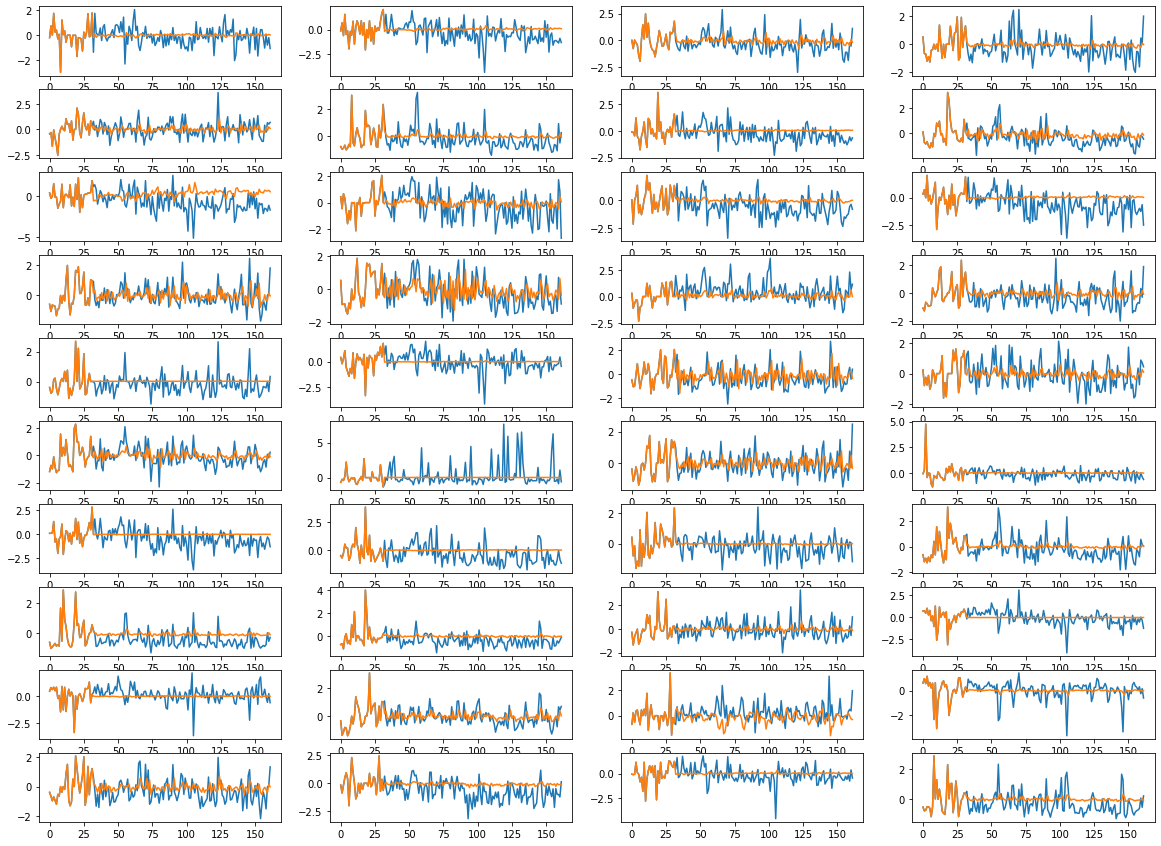

In [84]:
import matplotlib.pyplot as plt
# Plot generated graphs.
plt.figure(figsize=(20,15))

for i in range(40):
    plt.subplot(10,4,i+1)
    plt.plot(X_CASU_16_11_1_mag[i,:,0])
    plt.plot(X_CASU_16_11_1_mag_arima_0_0_1[i,:,0])
    # plt.plot(X_CASU_16_11_1_mag[i,:,0]-X_CASU_16_11_1_mag_arima_0_0_1[i,:,0])
    # plt.plot(np.maximum(0,np.log(X_train[i,:,0])))
    # plt.plot(y_train[i])

plt.show()

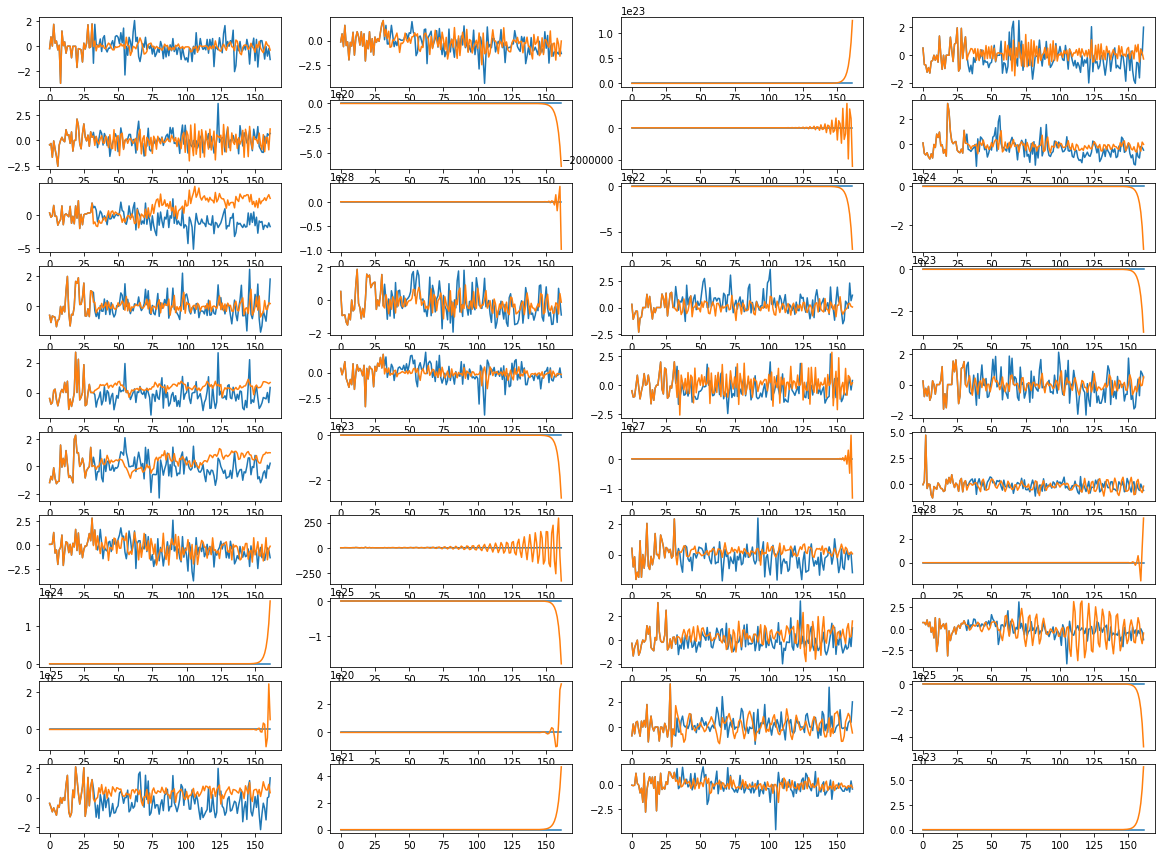

In [85]:
import matplotlib.pyplot as plt
# Plot generated graphs.
plt.figure(figsize=(20,15))

for i in range(40):
    plt.subplot(10,4,i+1)
    plt.plot(X_CASU_16_11_1_mag[i,:,0])
    plt.plot(X_CASU_16_11_1_mag_arima_0_0_2[i,:,0])
    # plt.plot(X_CASU_16_11_1_mag[i,:,0]-X_CASU_16_11_1_mag_arima_0_0_1[i,:,0])
    # plt.plot(np.maximum(0,np.log(X_train[i,:,0])))
    # plt.plot(y_train[i])

plt.show()

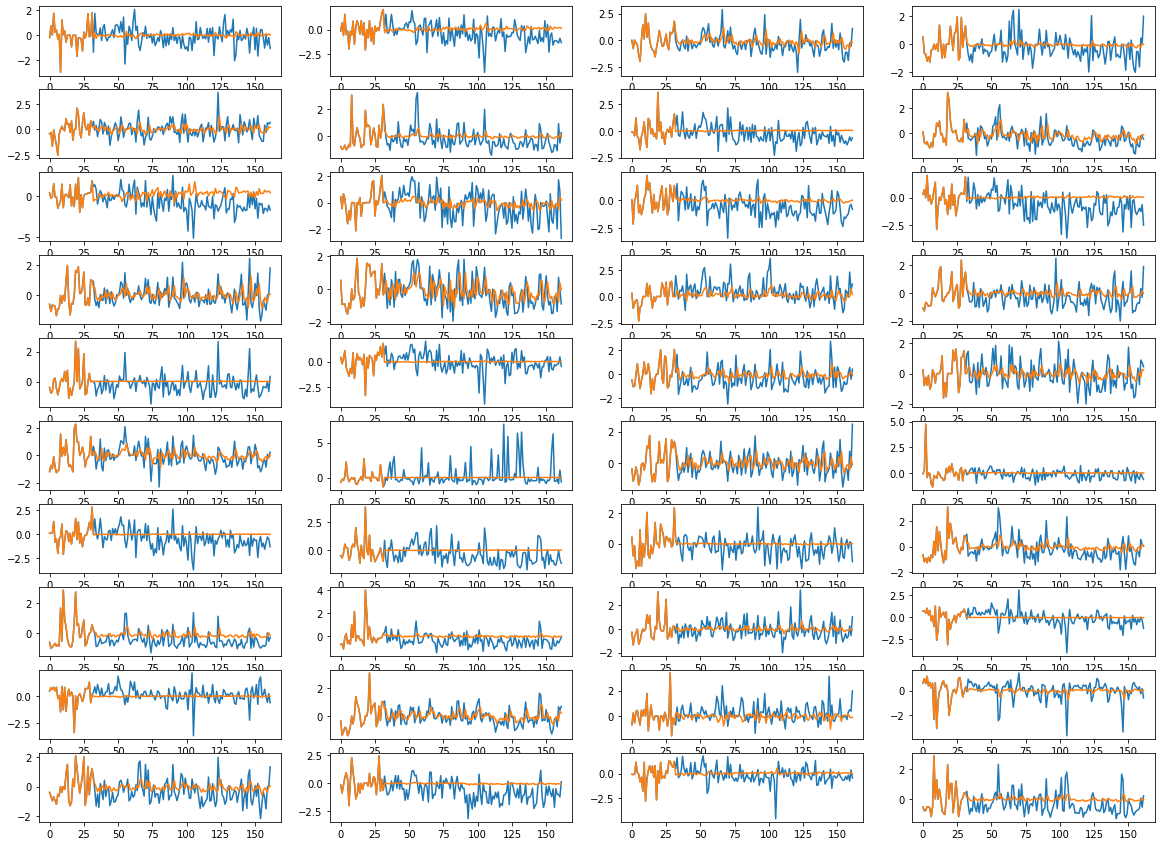

In [89]:
import matplotlib.pyplot as plt
# Plot generated graphs.
plt.figure(figsize=(20,15))

for i in range(40):
    plt.subplot(10,4,i+1)
    plt.plot(X_CASU_16_11_1_mag[i,:,0])
    plt.plot(X_CASU_16_11_1_mag_arima_1_0_0[i,:,0])
    # plt.plot(X_CASU_16_11_1_mag[i,:,0]-X_CASU_16_11_1_mag_arima_1_0_0[i,:,0])
    # plt.plot(np.maximum(0,np.log(X_train[i,:,0])))
    # plt.plot(y_train[i])

plt.show()

In [0]:
X_moa_arima = np.concatenate((X_gb[:5,:,:], X_moa_arima_0_0_2), axis=2)